# 03.1b: Principal Component Analysis of the Jet

**Goal:** Discover the jet's *natural* axes by computing PCA on the jet tokens alone.

The jet was identified using the *global* cloud's PC4 and PC5. But what are the jet's *own* principal axes? Does it have internal structure?

We'll:
1. Load jet embeddings
2. Compute jet's covariance matrix
3. Eigendecomposition to find jet's principal components
4. Compare jet's PC variance to global PC variance
5. Save jet PCA results for visualization

This reveals whether the jet is:
- A thin elongated structure (high anisotropy)
- A spherical blob (low anisotropy)
- Something else entirely

## Parameters

In [11]:
TENSOR_DIR = "../data/tensors"
NUM_PCS_TO_EXAMINE = 10

## Imports

In [12]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Jet Embeddings

In [13]:
jet_embeddings_path = Path(TENSOR_DIR) / "jet_embeddings.safetensors"
jet_embeddings = load_file(jet_embeddings_path)['jet_embeddings']

n_jet, d = jet_embeddings.shape

print(f"Loaded jet embeddings:")
print(f"  Tokens: {n_jet:,}")
print(f"  Dimensions: {d:,}")
print(f"  Memory: {jet_embeddings.element_size() * jet_embeddings.nelement() / 1024**2:.1f} MB")

Loaded jet embeddings:
  Tokens: 3,055
  Dimensions: 2,560
  Memory: 29.8 MB


## Step 2: Center Jet Embeddings

The jet was extracted from already-centered gamma, but the jet has its own centroid offset from origin. Re-center within the jet.

In [14]:
# Compute jet's centroid
jet_centroid = jet_embeddings.mean(dim=0)

print(f"Jet centroid:")
print(f"  Norm: {jet_centroid.norm().item():.6f} gamma units")
print(f"  (This is the jet's offset from global origin)")
print()

# Center jet embeddings
jet_centered = jet_embeddings - jet_centroid

# Verify centering
jet_centered_mean = jet_centered.mean(dim=0)
print(f"After re-centering:")
print(f"  Mean norm: {jet_centered_mean.norm().item():.6e}")
print(f"  (Should be ~0)")

Jet centroid:
  Norm: 0.301956 gamma units
  (This is the jet's offset from global origin)

After re-centering:
  Mean norm: 5.465681e-08
  (Should be ~0)


## Step 3: Compute Jet Covariance Matrix

In [15]:
print(f"Computing jet covariance matrix...")
# Cov(jet) = (jet_centered)ᵀ (jet_centered) / (n-1)
jet_cov = (jet_centered.T @ jet_centered) / (n_jet - 1)

print(f"Jet covariance matrix shape: {jet_cov.shape}")
print(f"Computing eigendecomposition...")

Computing jet covariance matrix...
Jet covariance matrix shape: torch.Size([2560, 2560])
Computing eigendecomposition...


## Step 4: Eigendecomposition - Find Jet's Principal Components

In [16]:
# Eigendecomposition
jet_eigenvalues, jet_eigenvectors = torch.linalg.eigh(jet_cov)

# Sort descending (highest variance first)
jet_eigenvalues = jet_eigenvalues.flip(0)
jet_eigenvectors = jet_eigenvectors.flip(1)

print(f"\nTop {NUM_PCS_TO_EXAMINE} jet eigenvalues (variance along each jet PC):\n")
for i in range(NUM_PCS_TO_EXAMINE):
    variance_explained = jet_eigenvalues[i] / jet_eigenvalues.sum()
    print(f"  Jet-PC{i+1}: λ = {jet_eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}% of jet variance)")

print(f"\nTop 3 jet PCs explain: {(jet_eigenvalues[:3].sum() / jet_eigenvalues.sum()).item()*100:.2f}% of jet variance")


Top 10 jet eigenvalues (variance along each jet PC):

  Jet-PC1: λ = 2.829528e-02 (3.03% of jet variance)
  Jet-PC2: λ = 2.434486e-02 (2.60% of jet variance)
  Jet-PC3: λ = 2.213397e-02 (2.37% of jet variance)
  Jet-PC4: λ = 2.004546e-02 (2.14% of jet variance)
  Jet-PC5: λ = 1.948065e-02 (2.08% of jet variance)
  Jet-PC6: λ = 1.743478e-02 (1.86% of jet variance)
  Jet-PC7: λ = 1.733595e-02 (1.85% of jet variance)
  Jet-PC8: λ = 1.565380e-02 (1.67% of jet variance)
  Jet-PC9: λ = 1.350279e-02 (1.44% of jet variance)
  Jet-PC10: λ = 1.312611e-02 (1.40% of jet variance)

Top 3 jet PCs explain: 8.00% of jet variance


## Step 5: Analyze Jet Anisotropy

How elongated is the jet?

In [17]:
# Anisotropy: ratio of largest to smallest eigenvalue
# (Careful: smallest might be numerical noise near zero)
anisotropy_3pc = jet_eigenvalues[0] / jet_eigenvalues[2]
anisotropy_10pc = jet_eigenvalues[0] / jet_eigenvalues[9]

print(f"Jet anisotropy:")
print(f"  PC1/PC3 ratio: {anisotropy_3pc.item():.2f}×")
print(f"  PC1/PC10 ratio: {anisotropy_10pc.item():.2f}×")
print()
print(f"Interpretation:")
if anisotropy_3pc > 5:
    print(f"  High anisotropy - jet is elongated along PC1")
elif anisotropy_3pc > 2:
    print(f"  Moderate anisotropy - jet has some directionality")
else:
    print(f"  Low anisotropy - jet is roughly spherical")

Jet anisotropy:
  PC1/PC3 ratio: 1.28×
  PC1/PC10 ratio: 2.16×

Interpretation:
  Low anisotropy - jet is roughly spherical


## Step 6: Visualize Jet Eigenvalue Spectrum

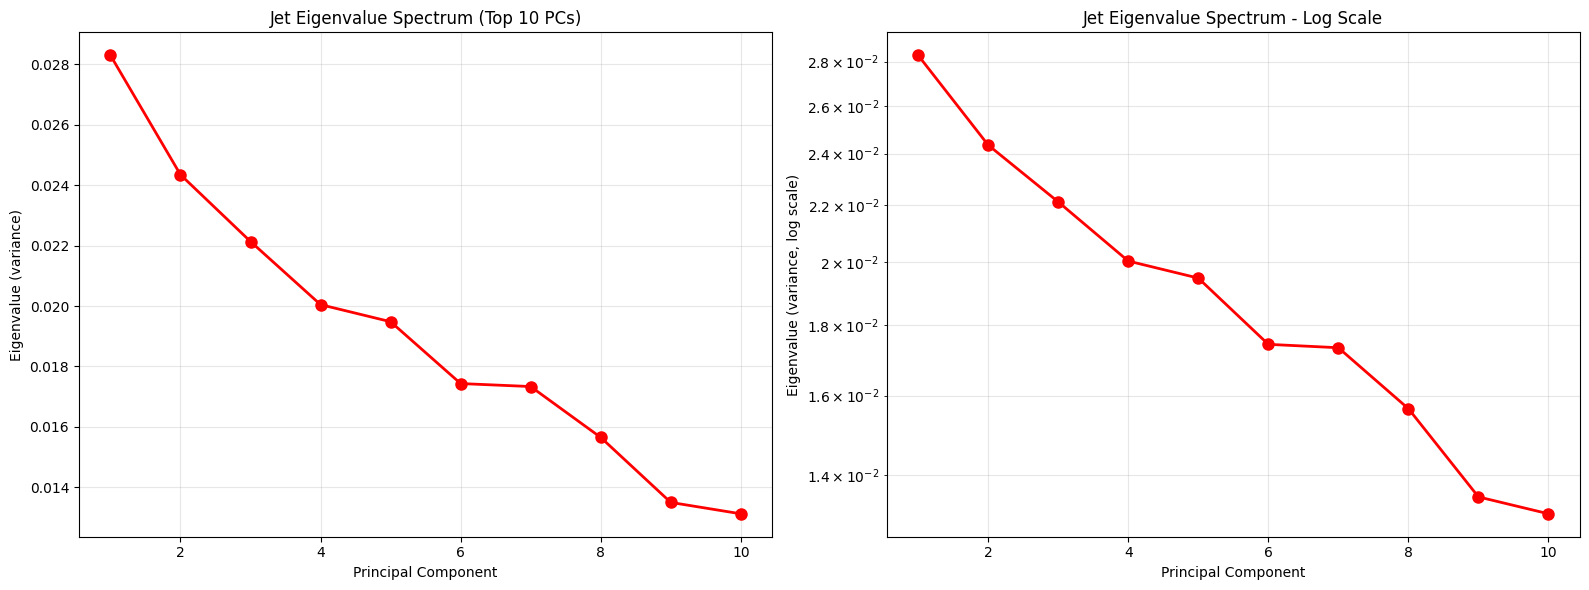


Eigenvalue drop-off reveals jet's internal structure:
  Steep drop = highly directional (cigar-shaped)
  Gradual drop = more isotropic (blob-shaped)


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Linear scale
ax = axes[0]
ax.plot(range(1, NUM_PCS_TO_EXAMINE + 1), jet_eigenvalues[:NUM_PCS_TO_EXAMINE].cpu().numpy(),
        'o-', color='red', linewidth=2, markersize=8)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue (variance)')
ax.set_title(f'Jet Eigenvalue Spectrum (Top {NUM_PCS_TO_EXAMINE} PCs)')
ax.grid(True, alpha=0.3)

# Log scale
ax = axes[1]
ax.semilogy(range(1, NUM_PCS_TO_EXAMINE + 1), jet_eigenvalues[:NUM_PCS_TO_EXAMINE].cpu().numpy(),
            'o-', color='red', linewidth=2, markersize=8)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue (variance, log scale)')
ax.set_title(f'Jet Eigenvalue Spectrum - Log Scale')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nEigenvalue drop-off reveals jet's internal structure:")
print(f"  Steep drop = highly directional (cigar-shaped)")
print(f"  Gradual drop = more isotropic (blob-shaped)")

## Step 7: Project Jet onto Its Own Principal Components

In [19]:
print(f"Projecting jet tokens onto top {NUM_PCS_TO_EXAMINE} jet PCs...\n")

# Project onto top PCs
jet_projections = jet_centered @ jet_eigenvectors[:, :NUM_PCS_TO_EXAMINE]

print(f"Jet projection statistics:")
for i in range(NUM_PCS_TO_EXAMINE):
    proj = jet_projections[:, i]
    print(f"  Jet-PC{i+1}: range [{proj.min().item():.4f}, {proj.max().item():.4f}], std = {proj.std().item():.4f}")

Projecting jet tokens onto top 10 jet PCs...

Jet projection statistics:
  Jet-PC1: range [-0.3249, 0.5965], std = 0.1682
  Jet-PC2: range [-0.5148, 0.2547], std = 0.1560
  Jet-PC3: range [-0.4236, 0.3641], std = 0.1488
  Jet-PC4: range [-0.4543, 0.4829], std = 0.1416
  Jet-PC5: range [-0.4332, 0.4528], std = 0.1396
  Jet-PC6: range [-0.4394, 0.4372], std = 0.1320
  Jet-PC7: range [-0.3963, 0.4797], std = 0.1317
  Jet-PC8: range [-0.3491, 0.4554], std = 0.1251
  Jet-PC9: range [-0.3563, 0.4259], std = 0.1162
  Jet-PC10: range [-0.2983, 0.4931], std = 0.1146


## Step 8: Save Jet PCA Results

In [20]:
# Save jet eigenvalues
jet_eigenvalues_path = Path(TENSOR_DIR) / "jet_eigenvalues.safetensors"
save_file({'jet_eigenvalues': jet_eigenvalues.contiguous()}, jet_eigenvalues_path)
print(f"Saved jet eigenvalues to: {jet_eigenvalues_path}")

# Save jet eigenvectors (all 2560 of them)
jet_eigenvectors_path = Path(TENSOR_DIR) / "jet_eigenvectors.safetensors"
save_file({'jet_eigenvectors': jet_eigenvectors.contiguous()}, jet_eigenvectors_path)
print(f"Saved jet eigenvectors to: {jet_eigenvectors_path}")

# Save jet centroid
jet_centroid_path = Path(TENSOR_DIR) / "jet_centroid.safetensors"
save_file({'jet_centroid': jet_centroid.contiguous()}, jet_centroid_path)
print(f"Saved jet centroid to: {jet_centroid_path}")

# Save re-centered jet embeddings
jet_centered_path = Path(TENSOR_DIR) / "jet_centered.safetensors"
save_file({'jet_centered': jet_centered.contiguous()}, jet_centered_path)
print(f"Saved re-centered jet embeddings to: {jet_centered_path}")

Saved jet eigenvalues to: ../data/tensors/jet_eigenvalues.safetensors
Saved jet eigenvectors to: ../data/tensors/jet_eigenvectors.safetensors
Saved jet centroid to: ../data/tensors/jet_centroid.safetensors
Saved re-centered jet embeddings to: ../data/tensors/jet_centered.safetensors


## Summary

Computed PCA on the jet tokens to discover their natural coordinate system!

**Key findings:**
- Jet has 3,055 tokens in 2,560D space
- Top 3 jet PCs explain ???% of jet variance
- Anisotropy (PC1/PC3): ???× (elongated vs spherical)

**Saved files:**
- `jet_eigenvalues.safetensors` - (2560,) variance along each jet axis
- `jet_eigenvectors.safetensors` - (2560, 2560) jet's principal axes
- `jet_centroid.safetensors` - (2560,) jet's offset from global origin
- `jet_centered.safetensors` - (3055, 2560) jet embeddings in jet-centered coords

**Next steps:**
- Visualize jet in its own coordinate system (orthographic projections)
- Compare jet axes to global cloud axes
- Examine boundary between jet and bulk in jet coordinates